In [2]:
import torch
import torchvision
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator, FuncFormatter, LogLocator
from math import sqrt
import pickle
import sys

sys.path.append('../Steerable/')
import Steerable.nn as snn
from Steerable.utils import rotate_image2D, rotate_image3D

# Figure 1

### Visualization of core operation of steerable convolution

Produced using mathcha.io

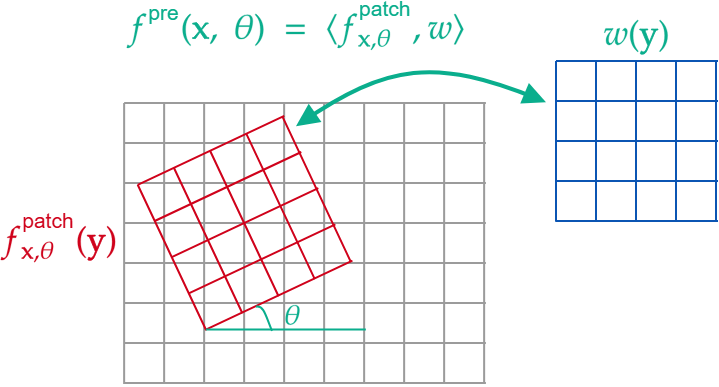

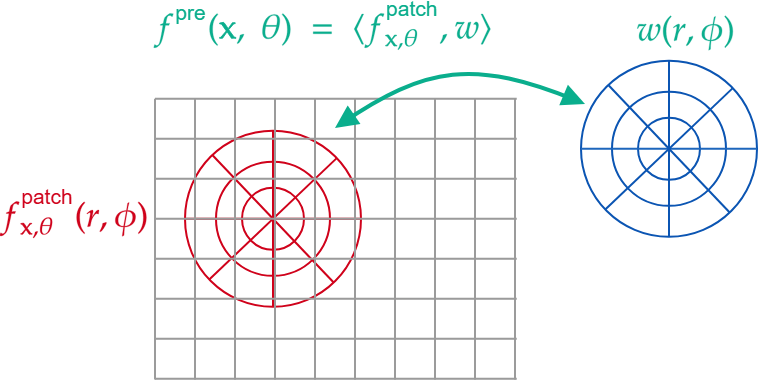

# Figure 2

### Interpolation Kernel

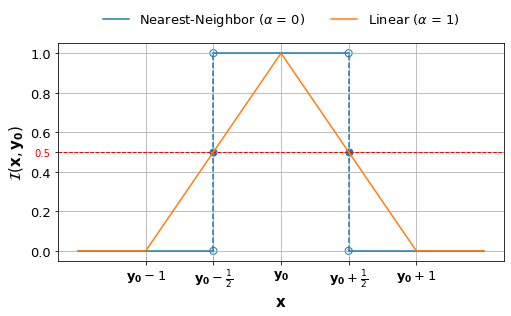

In [ ]:
def I(x, y, k):
    if k == 0:
        return torch.logical_and(x >= y - 0.5, x < y + 0.5).type(torch.float)
    elif k == 1:
        return torch.maximum(1-torch.abs(x - y), torch.tensor(0.0))
    else:
        raise ValueError('')

y0 = 0.0
epsilon = 1e-6

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

## Nearest-Neighbour
x_vals = torch.linspace(-0.5, 0.5 - epsilon, 400) 
ax.plot(x_vals, I(x_vals, y0, 0), color='C0', label=r'Nearest-Neighbor ($\alpha$ = 0)')
x_vals = torch.linspace(-1.5, -0.5 - epsilon, 400) 
ax.plot(x_vals, I(x_vals, y0, 0), color='C0', label=None)
x_vals = torch.linspace(0.5, 1.5, 400)
ax.plot(x_vals, I(x_vals, y0, 0), color='C0', label=None)
ax.vlines(y0-0.5, 0, 1, linestyles='--')
ax.vlines(y0+0.5, 0, 1, linestyles='--')
ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
ax.scatter([y0-0.5, y0+0.5], [0.5, 0.5], marker="o",  s=50)
ax.scatter([y0-0.5, y0+0.5]*2, [1,0,0,1], marker="o", facecolors='none', edgecolors="C0", s=50)

## Linear
x_vals = torch.linspace(-1.5, 1.5, 400) 
ax.plot(x_vals, I(x_vals, y0, 1), color='C1', label=r'Linear ($\alpha$ = 1)')

# Symbolic ticks
ax.set_xticks([-1, -0.5, 0, 0.5, 1],
           [r"$\mathbf{y_0}-1$", r"$\mathbf{y_0}-\frac{1}{2}$", r"$\mathbf{\mathbf{y_0}}$", r"$\mathbf{y_0}+\frac{1}{2}$", r"$\mathbf{\mathbf{y_0}}+1$"],
           fontsize=13)
ax.set_xlabel(r"$\mathbf{x}$", size=15)
ax.set_ylabel(r"$\mathcal{I}(\mathbf{x}, \mathbf{y_0})$", size=15)
ticks = sorted(list(plt.yticks()[0]) + [0.5])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{tick:.1f}' for tick in ticks])
for label in ax.get_yticklabels():
    if label.get_text() == '0.5':
        label.set_fontsize(10)   
        label.set_color('red')  
    else:
        label.set_fontsize(13)   


ax.set_ylim(-0.05, 1.05)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.2), ncol=2, fontsize=13, frameon=False)
ax.grid(True)
plt.show()

# Figure 3
### Spherical grid misalignment under right angle rotation

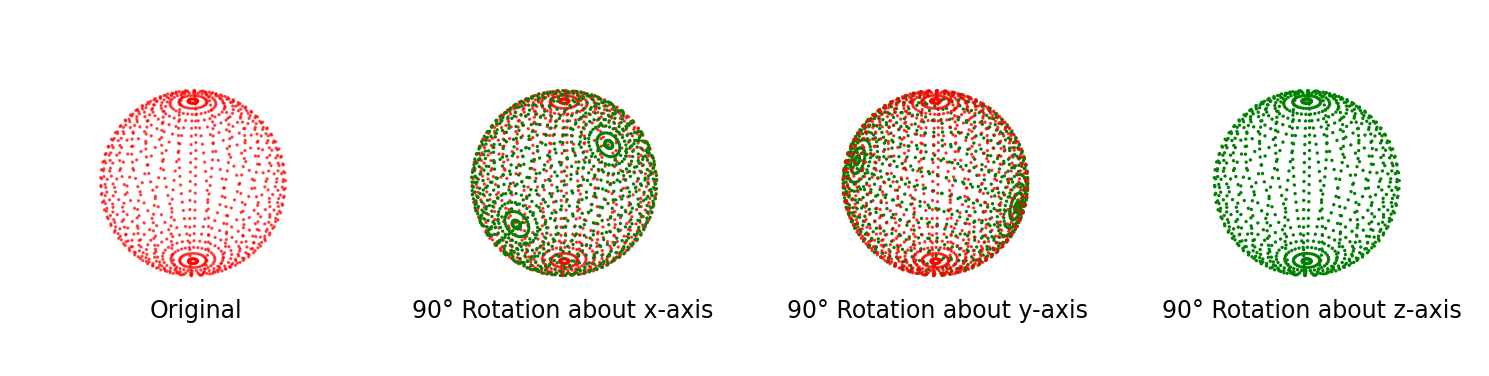

In [60]:
def spherical_grid_3d(n_angle):
    j = torch.arange(n_angle)
    theta, phi = torch.meshgrid(torch.pi * (j + 0.5) / n_angle, 2*torch.pi*(j+0.5) / n_angle, indexing='ij')
    x = (torch.sin(theta) * torch.cos(phi)).flatten()
    y = (torch.sin(theta) * torch.sin(phi)).flatten()
    z = torch.cos(theta).flatten()
    return torch.vstack([x, y, z])

def rotate_points(points, axis='x', angle_deg=90):
    angle_rad = np.radians(angle_deg)
    if axis == 'x':
        R = torch.tensor([[1, 0, 0],
                      [0, np.cos(angle_rad), -np.sin(angle_rad)],
                      [0, np.sin(angle_rad),  np.cos(angle_rad)]])
    elif axis == 'y':
        R = torch.tensor([[ np.cos(angle_rad), 0, np.sin(angle_rad)],
                      [0, 1, 0],
                      [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == 'z':
        R = torch.tensor([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                      [np.sin(angle_rad),  np.cos(angle_rad), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    return R.type(torch.float) @ points

def plot_rotated_vs_original(n_angle):
    points = spherical_grid_3d(n_angle)
    fig, axes = plt.subplots(nrows=1, ncols=4, subplot_kw={"projection": "3d"}, gridspec_kw={'hspace':0})
    fig.set_size_inches(15,4)
    
    for ax in axes:
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')

    # Plot original grid
    axes[0].scatter(points[0], points[1], points[2],
                color='red', s=2, alpha=0.6, label='Original')
    fig.text(0.103,0.175,s=f'Original', fontsize=17)

    for i, rotation_axis in enumerate(['x', 'y', 'z']):
        rotated = rotate_points(points, axis=rotation_axis, angle_deg=90)
        if rotation_axis in ['x', 'y']:
            # Plot original grid
            axes[i+1].scatter(points[0], points[1], points[2],
                    color='red', s=2, alpha=0.7, label='Original')

        # Plot rotated grid
        axes[i+1].scatter(rotated[0], rotated[1], rotated[2],
                   color='green', s=2, alpha=1.0, label=f'Rotated about {rotation_axis.upper()}')

        fig.text(0.25*i + 0.278,0.175,s=f'90° Rotation about {rotation_axis}-axis', fontsize=17)
        
    plt.tight_layout()
    plt.show()

# Main
plot_rotated_vs_original(32)

# Figure 4

### Equivariane Error vs Rotations

## Gaussian Dataset and Equivariance Check Function

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
degrees = torch.arange(0, 361, 5)

class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, shape, mean=0.0, std=1.0, size=500):
        self.mean = mean
        self.std = std
        self.shape = shape
        self.size = size

    def __getitem__(self, idx):
        if idx >= self.size:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.size}')
        image = torch.randn(self.shape) * self.std + self.mean
        label = 0
        return image, label
    
    def __len__(self):
        return self.size
    

def check_equivariance(models, dataset, transfomations=None):
    models = models if type(models) is list else [models]
    device = next(models[0].parameters()).device
    transfomations = transfomations if type(transfomations) is list else [transfomations]
    values = torch.zeros(len(dataset), len(models), len(transfomations), len(degrees))
    for i in range(len(dataset)):
        inputs, _ = dataset[i]
        norm = torch.abs(inputs).mean()
        for j, model in enumerate(models):
            with torch.no_grad():
                for parameters in model.parameters():
                    parameters.copy_(torch.randn_like(parameters))
                for k, transfomation in enumerate(transfomations):
                    inputs_transformed = torch.stack([transfomation(inputs, degree) for degree in degrees], dim=0).to(device)
                    with torch.no_grad():
                        outputs = model(inputs.unsqueeze(0).to(device))
                        outputs_transformed = model(inputs_transformed)
                        values[i, j, k] = 100 * (outputs-outputs_transformed).max(dim=1)[0].abs() / norm
    
        print(f'Simulation : {i+1} / {len(dataset)}', end='\r')
        
    mean, std = values.mean(dim=0), values.std(dim=0)
    return torch.stack([mean - 1.96*std / sqrt(len(dataset)), mean + 1.96*std / sqrt(len(dataset))], dim=-1)

## Models

In [13]:
class Model2D(torch.nn.Module):
    def __init__(self, freq_cutoff, interpolation):
        super().__init__()
        n_angle = 256
        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 4, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation),
            snn.SE2BatchNorm(),
            snn.SE2ConvType2(4, 16, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation),
            snn.SE2NormFlatten()
        )
        
    def forward(self,x):
        return self.network(x.type(torch.cfloat))

class Model3D(torch.nn.Module):
    def __init__(self, freq_cutoff, interpolation) -> None:
        super().__init__()
        n_angle = 256
        channel = lambda x: [4*x]*(freq_cutoff+1)
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, channel(1), 5, n_angle=n_angle, padding='same', interpolation_type=interpolation),
            snn.SE3BatchNorm(),
            snn.SE3Conv(channel(1), channel(4), 5, n_angle=n_angle, padding='same', interpolation_type=interpolation),
            snn.SE3NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))

In [14]:
interpolation_orders = [0, 1, -1]

print('2D Simulations')
errors_2d = check_equivariance(models=[Model2D(freq_cutoff=4, interpolation=i).to(device) for i in interpolation_orders], 
                               dataset=GaussianDataset(shape =(1,28,28), size=100), 
                               transfomations=lambda x, degree:rotate_image2D(x, degree, order=1))

print('3D Simulations')
errors_3d = check_equivariance(models=[Model3D(freq_cutoff=0, interpolation=i).to(device) for i in interpolation_orders],
                               dataset=GaussianDataset(shape =(1,32,32,32), size=100), 
                               transfomations=[lambda x, degree:rotate_image3D(x, (0, degree, 0), order=1), 
                                               lambda x, degree:rotate_image3D(x, (degree, 0, 0), order=1)])

errors = torch.cat([errors_2d, errors_3d], dim=1)

2D Simulations
3D Simulations00 / 100


## Plot

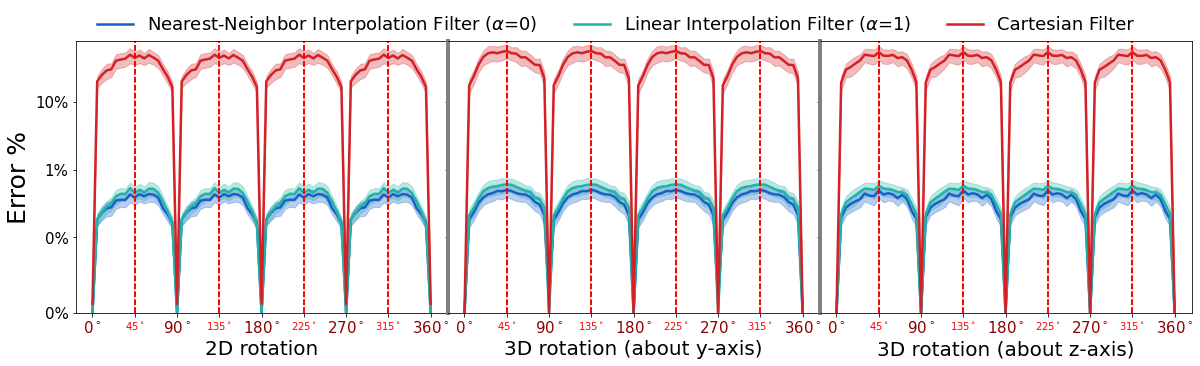

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=errors.shape[1], sharey=True, gridspec_kw={'wspace':0})
fig.set_size_inches(20,5)

colors = {
    r'Nearest-Neighbor Interpolation Filter ($\alpha$=0)': "#1A5ECD",  
    r'Linear Interpolation Filter ($\alpha$=1)': "#21B3A7",            
    'Cartesian Filter': "#D42127"          
}
labels = list(colors.keys())

for i in interpolation_orders:
    for j, ax in enumerate(axes):
        ax.plot(degrees, errors[i,j,:,:].mean(dim=-1), color=colors[labels[i]], label=labels[i], linewidth=2.5)
        ax.fill_between(degrees, errors[i,j,:,0], errors[i,j,:,1], color=colors[labels[i]], alpha=0.3)

        ax.set_xticks([45*i for i in range(degrees.max().item()//45 + 1)])
        ax.tick_params(axis='both', labelsize=15)
        ax.tick_params(axis='x', labelcolor='darkred')
        ticks = ax.xaxis.get_major_ticks()
        if j>0:
            ax.spines['left'].set_linewidth(4)
            ax.spines['left'].set_edgecolor('grey')
        
        for k in [1, 3, 5, 7]:
            if -len(ticks) <= k < len(ticks):
                ticks[k].label1.set_fontsize(10)
                ticks[k].label1.set_color('red')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: rf"${x}^\circ$"))
        for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
            ax.axvline(intercept, linestyle='dashed', color='red')
        ax.set_yscale('symlog', linthresh=0.1, linscale=1.0)
        ax.yaxis.set_major_formatter(PercentFormatter(100))
        ax.set_ylim((0.0, errors.max().item()+10))
        

axes[0].set_ylabel('Error %', size=25)
axes[0].set_xlabel('2D rotation', size=20)
axes[1].set_xlabel('3D rotation (about y-axis)', fontsize=20)
axes[2].set_xlabel('3D rotation (about z-axis)', fontsize=20)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.0), ncol=3, fontsize=18, frameon=False)


plt.show()

# Figure 5

### Perfomance comparison

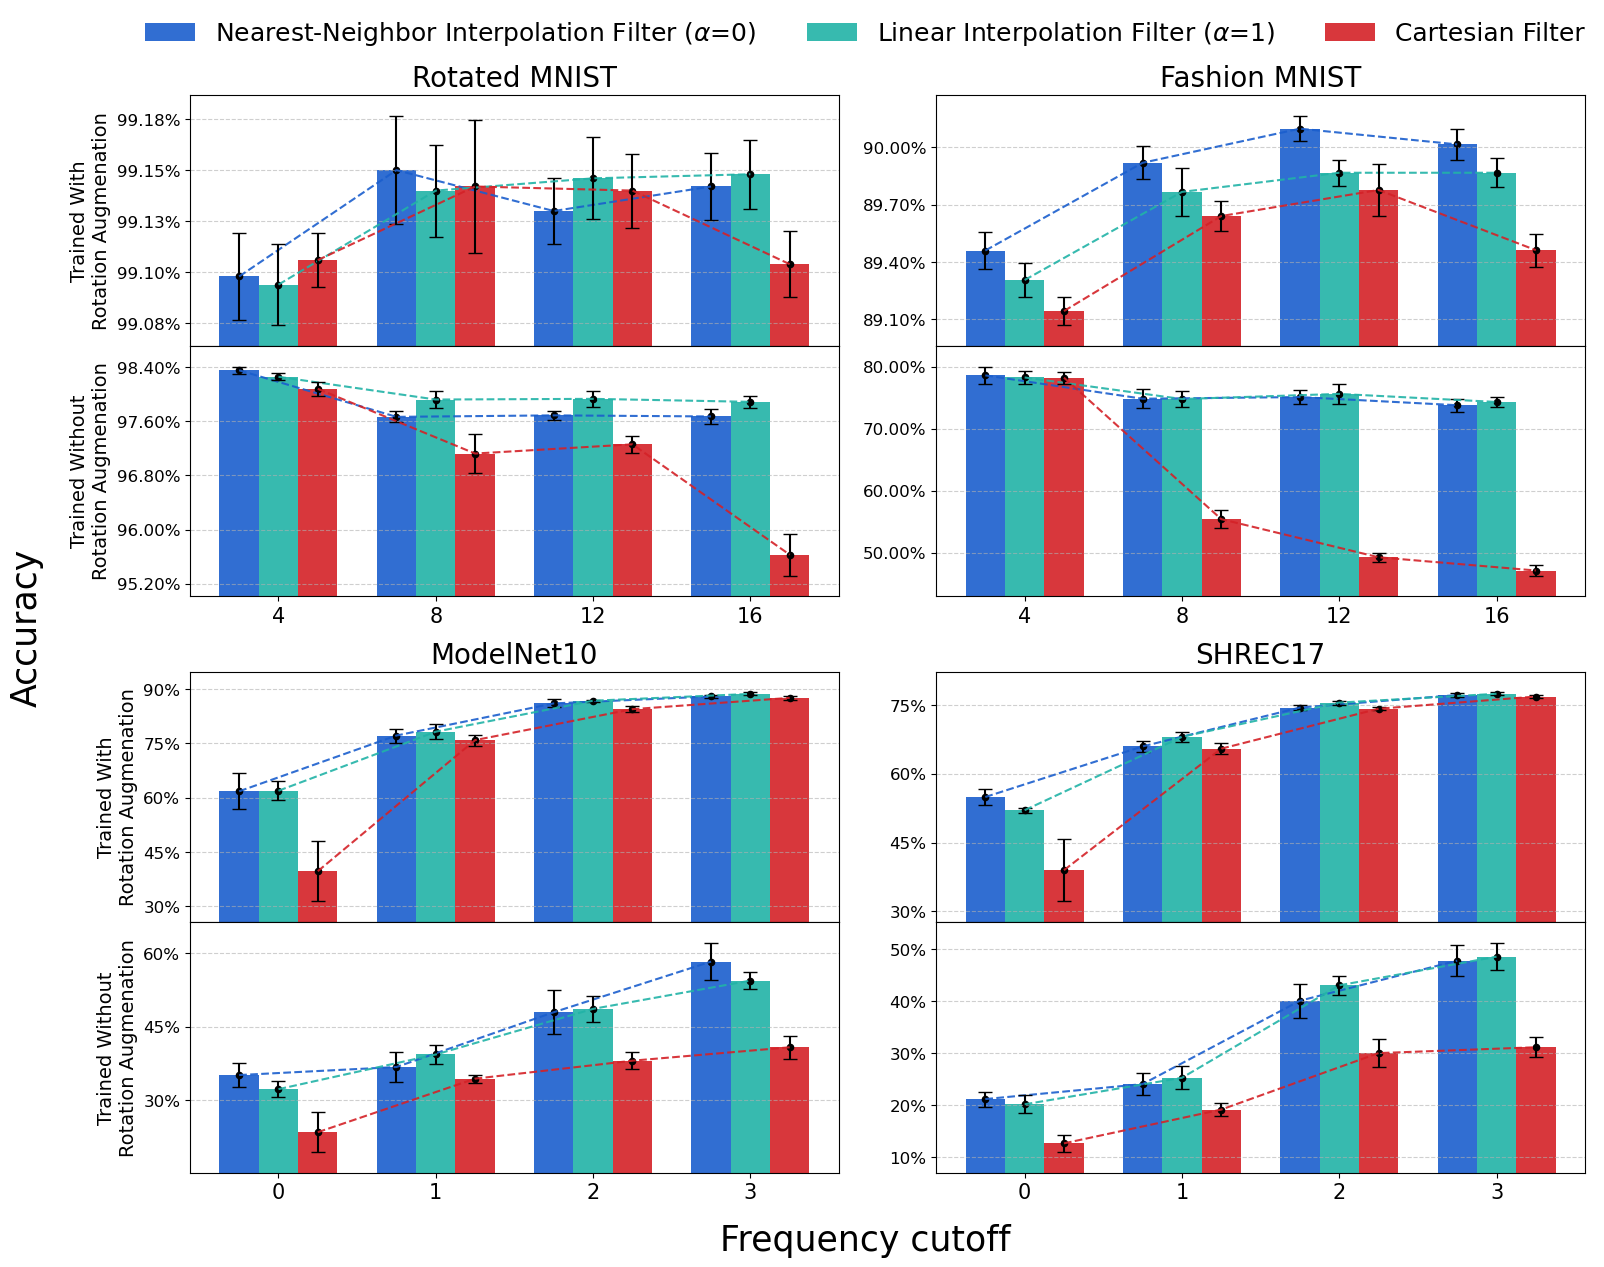

In [6]:
datasets = ['RMNIST', 'FMNIST', 'ModelNet10', 'SHREC17']
stats = []
for dataset in datasets:
    with open(f'stats/{dataset}_stats.pkl', 'rb') as file: 
        stats.append(torch.from_numpy(pickle.load(file)))
        
stats = torch.stack(stats, dim=0)

datasets = ['Rotated MNIST', 'Fashion MNIST', 'ModelNet10', 'SHREC17']
interpolation_orders = [0, 1, -1]

colors = {
    r'Nearest-Neighbor Interpolation Filter ($\alpha$=0)': "#1A5ECD",  
    r'Linear Interpolation Filter ($\alpha$=1)': "#21B3A7",            
    'Cartesian Filter': "#D42127"          
}
labels = list(colors.keys())

position = [-1, 0, 1]



fig = plt.figure(figsize=(18, 14))
outer = fig.add_gridspec(2, 2, wspace=0.15, hspace=0.15)  # 2x2 datasets

axes = {}

for idx, dataset in enumerate(datasets):
    row, col = divmod(idx, 2)  # place dataset in 2x2 grid
    inner = outer[row, col].subgridspec(2, 1, hspace=0)   # stacked rotated/non-rotated
    dataset_axes = [fig.add_subplot(inner[j]) for j in range(2)]
    axes[dataset] = dataset_axes
    if idx <= 1:
        freq_cutoffs = torch.tensor([4, 8, 12, 16])
        width = 1
    else:
        freq_cutoffs = torch.tensor([0, 1, 2, 3])
        width = 0.25

    for r, rotate in enumerate([1, 0]):  # r=0 → Non-rotated, r=1 → Rotated
        ax = dataset_axes[r]
        values = stats[idx, :, :, 0, rotate, 0].roll(-1, dims=0)
        errors = stats[idx, :, :, 0, rotate, 1].roll(-1, dims=0)

        for j, order in enumerate(interpolation_orders):
            ax.bar(freq_cutoffs + position[j]*width, values[order], yerr=errors[order], label=labels[j], width=width,
                capsize=5, color=colors[labels[j]], alpha=0.9)
            ax.plot(freq_cutoffs + position[j]*width, values[order], linestyle='--', color=colors[labels[j]], alpha=0.9)
            ax.scatter(freq_cutoffs + position[j]*width, values[order], color='black', s=20)

        # x-axis
        ax.set_xticks(freq_cutoffs)
        ax.tick_params(axis='x', labelsize=15)
        
        # y-axis
        low, high = (values - errors).min(), (values+errors).max()
        buffer = (high-low) / 10
        ax.set_ylim(low-buffer, high+buffer)
        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  
        ax.yaxis.set_major_formatter(PercentFormatter(100, decimals=2 if idx<=1 else 0))
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        ax.tick_params(axis='y', labelsize=12)

        if col == 0:  # only leftmost datasets get y-labels
            ax.set_ylabel(f"Trained With{'out' if rotate==0 else ''}\nRotation Augmenation", fontsize=14)

        if r == 0:  # top row only → dataset title
            ax.set_title(dataset, fontsize=20)

# Legend and super labels
handles, labels = axes[datasets[0]][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.95),
           ncol=3, frameon=False, fontsize=18)

fig.supxlabel("Frequency cutoff", fontsize=25, y=0.05)
fig.supylabel("Accuracy", fontsize=25, x=0.025)

plt.show()

# Figure 6

### Sensitivity Analysis

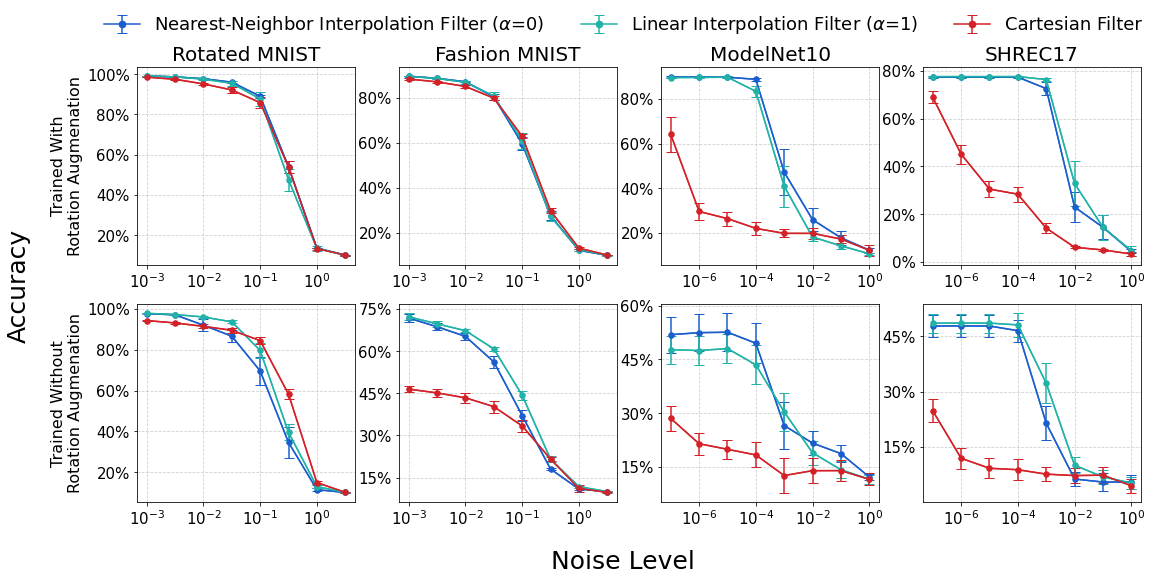

In [3]:
datasets = ['RMNIST', 'FMNIST', 'ModelNet10', 'SHREC17']
stats = []
for dataset in datasets:
    with open(f'stats/{dataset}_stats.pkl', 'rb') as file: 
        stats.append(torch.from_numpy(pickle.load(file)))

stats = torch.stack(stats, dim=0)

datasets = ['Rotated MNIST', 'Fashion MNIST', 'ModelNet10', 'SHREC17']
interpolation_orders = [0, 1, -1]
freq_cutoffs = torch.tensor([4, 8, 12, 16])

colors = {
    r'Nearest-Neighbor Interpolation Filter ($\alpha$=0)': "#1A5ECD",  
    r'Linear Interpolation Filter ($\alpha$=1)': "#21B3A7",            
    'Cartesian Filter': "#D42127"          
}
labels = list(colors.keys())

position = [-1, 0, 1]
width = 1
k = -1
fig, axes = plt.subplots(nrows=2, ncols=len(stats))
fig.set_size_inches(18, 8)

for idx, dataset in enumerate(datasets):
    if idx <= 1:
        noise_levels = torch.logspace(-3, 0.5, 8)
    else:
        noise_levels = torch.logspace(-7, 0, 8)
    for r, rotate in enumerate([1, 0]):  # r=0 → Non-rotated, r=1 → Rotated
        ax = axes[1-rotate][idx]
        values = stats[idx, :, k, 1:, rotate, 0].roll(-1, dims=0) * 100
        errors = stats[idx, :, k, 1:, rotate, 1].roll(-1, dims=0) * 100

        for j, order in enumerate(interpolation_orders):
            ax.plot(noise_levels, values[order], color=colors[labels[j]], alpha=0.9)
            ax.errorbar(noise_levels, y=values[order], yerr=errors[order], 
                        fmt='-o', capsize=5, markersize=5.5, 
                        color=colors[labels[j]], label=labels[j])
            

        # x-axis
        ax.set_xscale('log', base=10)
        ax.xaxis.set_major_locator(LogLocator(base=10, numticks=5))
        ax.tick_params(axis='x', labelsize=15)
        
        
        
        # y-axis
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.yaxis.set_major_formatter(PercentFormatter(100))
        ax.grid(linestyle="--", alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

        if idx == 0:  # only leftmost datasets get y-labels
            ax.set_ylabel(f"Trained With{'out' if rotate==0 else ''}\nRotation Augmenation", fontsize=16)

        if rotate == 1:  # top row only → dataset title
            ax.set_title(dataset, fontsize=20)

# Legend and super labels
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False, fontsize=18, markerscale=1.2)

fig.supxlabel("Noise Level", fontsize=25, y=0.0)
fig.supylabel("Accuracy", fontsize=25, x=0.025)

plt.show()

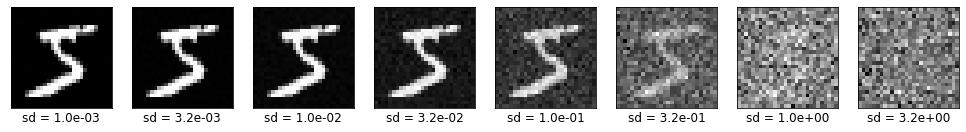

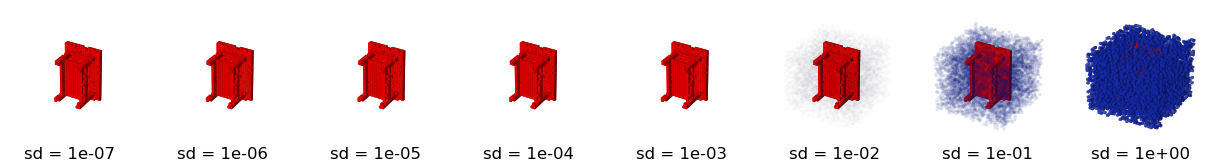

In [4]:
dataset = torchvision.datasets.MNIST('../Data/RMNIST/data/', train=True, transform=torchvision.transforms.ToTensor())
noise_levels = torch.logspace(-3, 0.5, 8)
fig, axes = plt.subplots(nrows=1, ncols=len(noise_levels))
fig.set_size_inches(17, 5)
for i, sd in enumerate(noise_levels):
    noise = torch.randn(28,28) * sd
    axes[i].imshow(dataset[0][0][0]+noise, cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel(f'sd = {sd:.1e}', fontsize=12)
    
plt.show()


noise_levels = torch.logspace(-7, 0, 8)
fig, axes = plt.subplots(nrows=1, ncols=len(noise_levels), subplot_kw={'projection' : '3d'})
fig.set_size_inches(17, 5)

with h5py.File("../Data/ModelNet/data/ModelNet10_32.hdf5", 'r+') as file:
    image = torch.from_numpy(file['train_inputs'][0][0])

for i, sd in enumerate(noise_levels):
    noise = torch.randn_like(image) * sd
    
    # Prepare colors with varying transparency
    colors = np.zeros((*noise.shape, 4)) 
    colors[..., 0] = 0.1
    colors[..., 1] = 0.2
    colors[..., 2] = 0.8 
    colors[..., 3] = np.clip((noise - noise.min()) / (noise.max() - noise.min() + 1e-9), 0.0, 1.0) * sd
    
    # Threshold for showing voxels
    threshold = noise.max() * 0.2
    axes[i].voxels(noise > threshold, facecolors=colors)
    axes[i].voxels(image, facecolors='red')
    axes[i].set_axis_off()
    fig.text(0.06 + i/len(noise_levels), 0.275, f"sd = {sd:.0e}", ha='center', fontsize=16.5)
    
plt.tight_layout()
plt.show()

# Figure 7

### Sensitivity Analysis All

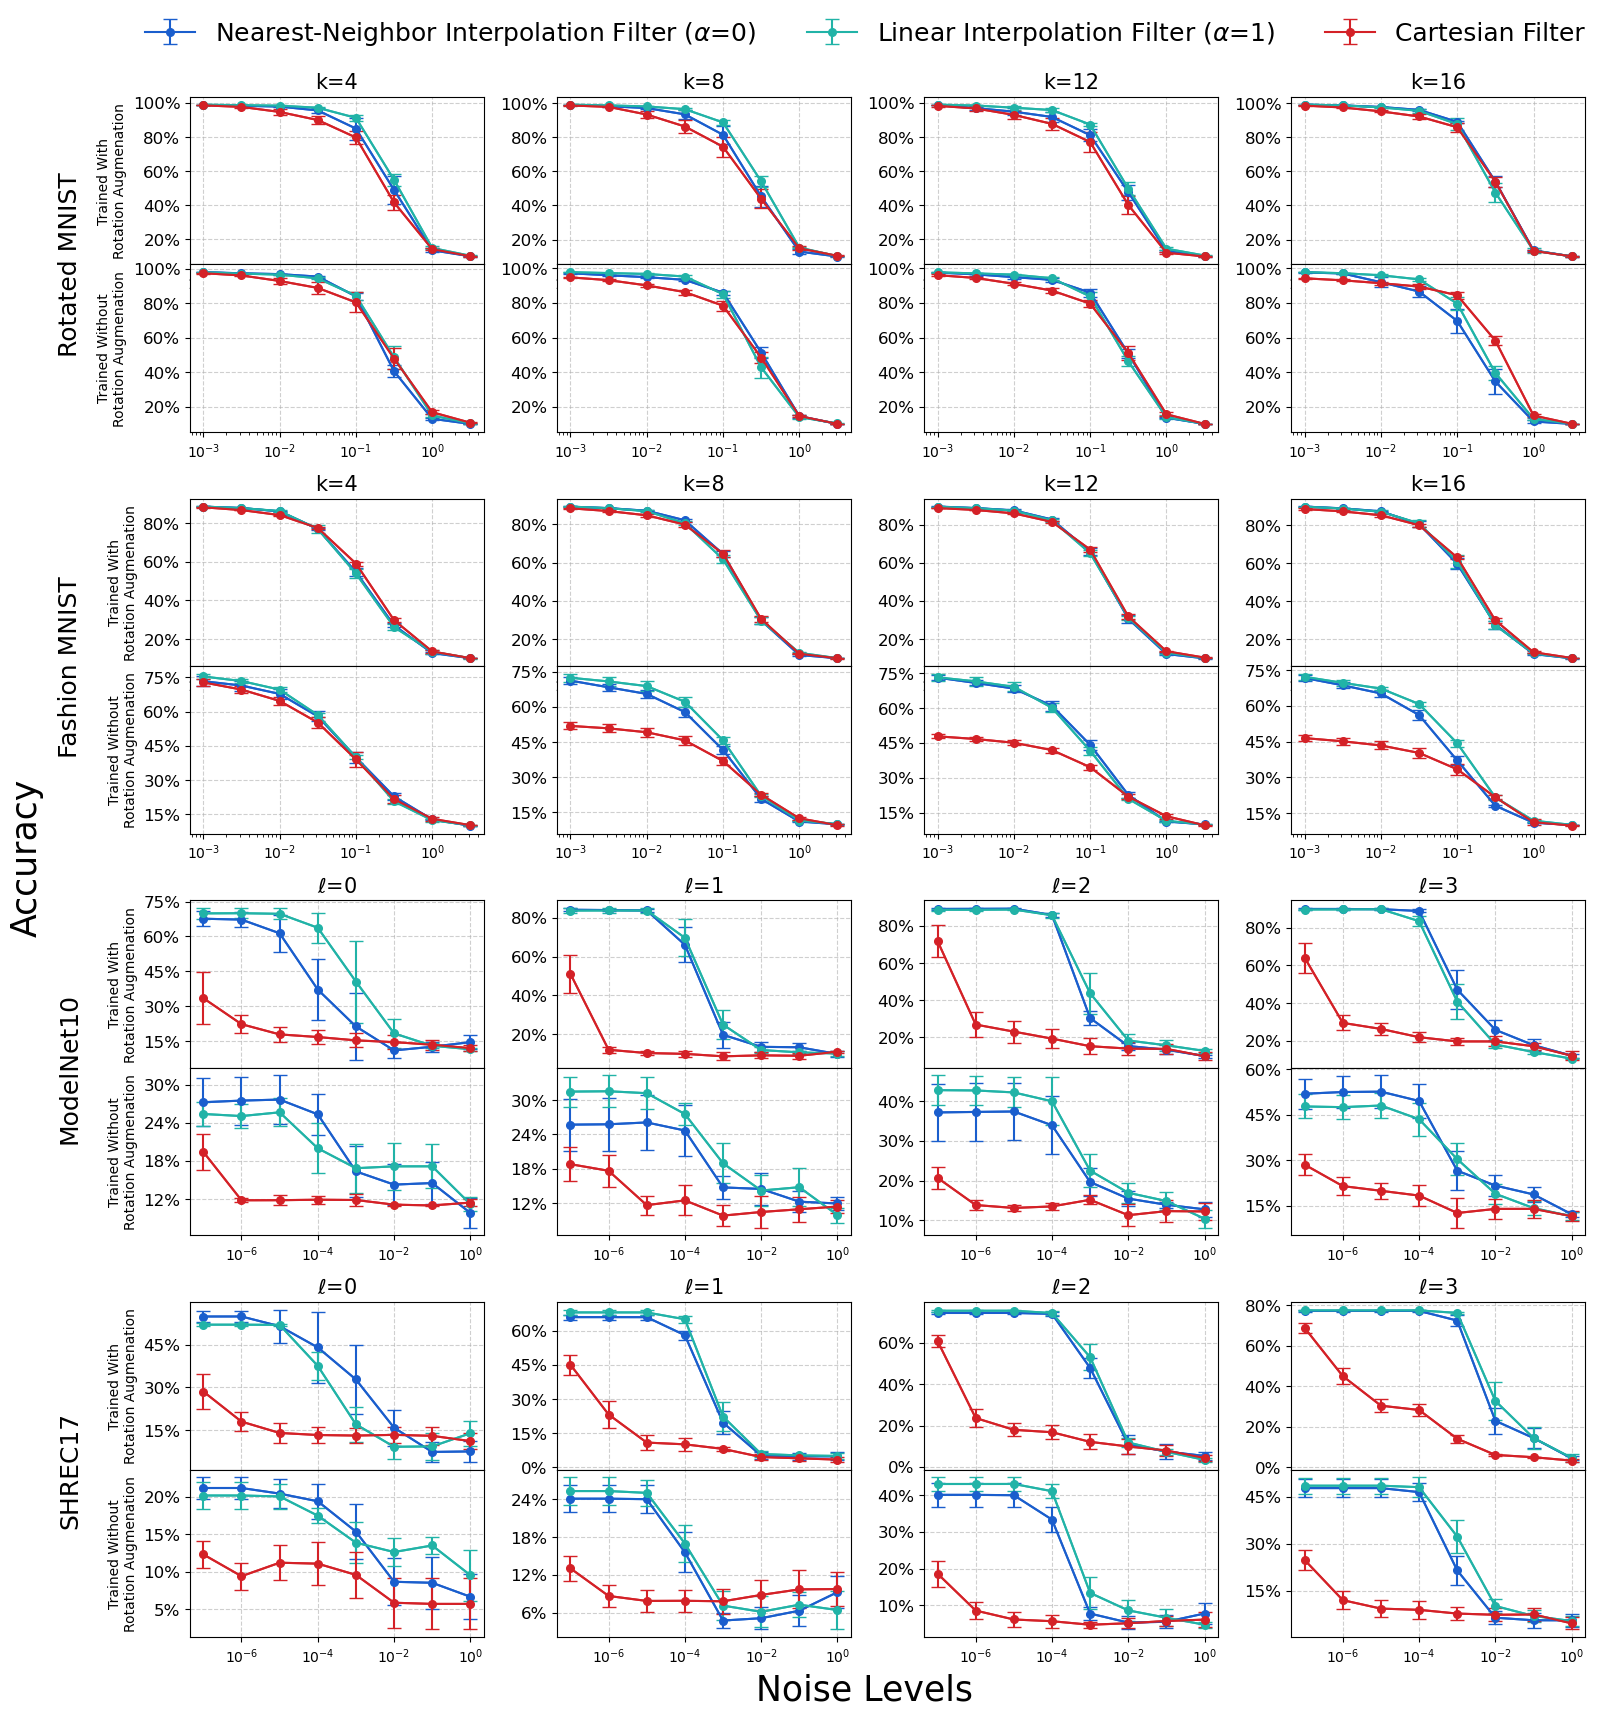

In [3]:
datasets = ['RMNIST', 'FMNIST', 'ModelNet10', 'SHREC17']
stats = []
for dataset in datasets:
    with open(f'stats/{dataset}_stats.pkl', 'rb') as file: 
        stats.append(torch.from_numpy(pickle.load(file)))
        
stats = torch.stack(stats, dim=0)

datasets = ['Rotated MNIST', 'Fashion MNIST', 'ModelNet10', 'SHREC17']
interpolation_orders = [0, 1, -1]
freq_cutoffs = torch.tensor([4, 8, 12, 16])

colors = {
    r'Nearest-Neighbor Interpolation Filter ($\alpha$=0)': "#1A5ECD",  
    r'Linear Interpolation Filter ($\alpha$=1)': "#21B3A7",            
    'Cartesian Filter': "#D42127"          
}
labels = list(colors.keys())
position = [-1, 0, 1]
width = 1


fig = plt.figure(figsize=(18, 20))
outer = fig.add_gridspec(len(datasets), 1, wspace=0, hspace=0.20) 

axes = {}

for idx, dataset in enumerate(datasets):
    inner = outer[idx].subgridspec(2, stats.shape[2], hspace=0, wspace=0.25) 
    dataset_axes = [[fig.add_subplot(inner[i,j]) for j in range(stats.shape[2])] for i in range(2)]
    
    if idx <= 1:
        noise_levels = torch.logspace(-3, 0.5, 8)
    else:
        noise_levels = torch.logspace(-7, 0, 8)
    
    axes[dataset] = dataset_axes
    x0 = dataset_axes[0][0].get_position().x0
    y0, y1 = dataset_axes[0][0].get_position().y0, dataset_axes[1][0].get_position().y1
    fig.text(x0 - 0.06, (y0 + y1) / 2, dataset, va='center', ha='right', rotation='vertical', fontsize=18)

    for k in range(stats.shape[2]):
        for r, rotate in enumerate([1, 0]):
            # Values
            values = stats[idx, :, k, 1:, rotate, 0].roll(-1, dims=0) * 100
            errors = stats[idx, :, k, 1:, rotate, 1].roll(-1, dims=0) * 100
            
            # Plot
            ax = dataset_axes[r][k]
            for j, order in enumerate(interpolation_orders):
                ax.plot(noise_levels, values[order], color=colors[labels[j]], alpha=0.9)
                ax.errorbar(noise_levels, y=values[order], yerr=errors[order], 
                        fmt='-o', capsize=5, markersize=5.5, 
                        color=colors[labels[j]], label=labels[j])
                    
            # x-axis
            ax.set_xscale('log', base=10)
            ax.tick_params(axis='x', labelsize=10)
            
            
            # yaxis
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            ax.grid(linestyle="--", alpha=0.6)
            ax.yaxis.set_major_formatter(PercentFormatter(100, 0))
            ax.tick_params(axis='y', labelsize=12)
            if k == 0:
                ax.set_ylabel(f"Trained With{'out' if rotate==0 else ''}\nRotation Augmenation", fontsize=10)
            else:
                ax.tick_params(axis='y')  # hides y-ticks and labels
            
            # Subtitle
            if r == 0:
                if idx <= 1:
                    ax.set_title(f"k={k*4+4}", fontsize=15)
                else:
                    ax.set_title(rf"$\ell$={k}", fontsize=15)

# Legend and super labels
handles, labels = axes[datasets[0]][0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.93),
           ncol=3, frameon=False, fontsize=18)

fig.supxlabel("Noise Levels", fontsize=25, y=0.075)
fig.supylabel("Accuracy", fontsize=25, x=0.025)
plt.show()
